In [1]:
# 유전 알고리즘을 활용한 머신러닝 입력 최적화 및 대안 제안 메소드
# Part 5. 사교육비가 고민이세요? 실습
# Fast Campus / (주)데이원컴퍼니

#**1. 모듈 설치 및 호출**

In [2]:
!pip install geneticalgorithm

     |████████████████████████████████| 44 kB 1.5 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15095 sha256=baab16ba5427737ae4b59d469ebfa4e49cf6fb046ac3ab4f960c07a55a1744f3
  Stored in directory: /root/.cache/pip/wheels/68/b5/a5/67c4364c354e141f5a1bd3ec568126f77877ab7554cf5af8cb
Successfully built func-timeout


In [3]:
import copy
import math
import itertools
from random import randint

import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from xgboost import XGBRegressor
from geneticalgorithm import geneticalgorithm


pd.set_option('display.max_columns', None)

# **2. 데이터 로드 및 탐색적 데이터 분석**

In [4]:
# student-mat.csv 데이터 파일을 Colab에 업로드
# Data link: https://archive.ics.uci.edu/ml/datasets/student+performance
# 두 과목 성적중 수학 성적 데이터 (student-mat.csv) 사용

from google.colab import files, drive
file_uploaded = files.upload()

Saving student-mat.csv to student-mat.csv


In [5]:
# Colab에 데이터 파일을 올려놓은 경우
# drive.mount('./content')
! ls /content

sample_data  student-mat.csv


In [6]:
raw_data = pd.read_csv('student-mat.csv', delimiter=';')
raw_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10


In [7]:
# # Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
# 1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
# 2 sex - student's sex (binary: "F" - female or "M" - male)
# 3 age - student's age (numeric: from 15 to 22)
# 4 address - student's home address type (binary: "U" - urban or "R" - rural)
# 5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
# 6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
# 7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
# 8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
# 9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
# 10 Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
# 11 reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
# 12 guardian - student's guardian (nominal: "mother", "father" or "other")
# 13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
# 14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
# 15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)
# 16 schoolsup - extra educational support (binary: yes or no)
# 17 famsup - family educational support (binary: yes or no)
# 18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
# 19 activities - extra-curricular activities (binary: yes or no)
# 20 nursery - attended nursery school (binary: yes or no)
# 21 higher - wants to take higher education (binary: yes or no)
# 22 internet - Internet access at home (binary: yes or no)
# 23 romantic - with a romantic relationship (binary: yes or no)
# 24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
# 25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)
# 26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)
# 27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
# 28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
# 29 health - current health status (numeric: from 1 - very bad to 5 - very good)
# 30 absences - number of school absences (numeric: from 0 to 93)

# # these grades are related with the course subject, Math or Portuguese:
# 31 G1 - first period grade (numeric: from 0 to 20)
# 31 G2 - second period grade (numeric: from 0 to 20)
# 32 G3 - final grade (numeric: from 0 to 20, output target)

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [9]:
raw_data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [10]:
raw_data.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [11]:
for i in list(raw_data):
    print(raw_data[i].value_counts())
    print('\n')

GP    349
MS     46
Name: school, dtype: int64


F    208
M    187
Name: sex, dtype: int64


16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64


U    307
R     88
Name: address, dtype: int64


GT3    281
LE3    114
Name: famsize, dtype: int64


T    354
A     41
Name: Pstatus, dtype: int64


4    131
2    103
3     99
1     59
0      3
Name: Medu, dtype: int64


2    115
3    100
4     96
1     82
0      2
Name: Fedu, dtype: int64


other       141
services    103
at_home      59
teacher      58
health       34
Name: Mjob, dtype: int64


other       217
services    111
teacher      29
at_home      20
health       18
Name: Fjob, dtype: int64


course        145
home          109
reputation    105
other          36
Name: reason, dtype: int64


mother    273
father     90
other      32
Name: guardian, dtype: int64


1    257
2    107
3     23
4      8
Name: traveltime, dtype: int64


2    198
1    105
3     65
4     27
Name: studytime,

#**3. 피쳐 엔지니어링**

In [12]:
int_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime',
                'failures', 'famrel', 'freetime', 'goout', 'Dalc',
                'Walc', 'health', 'absences', 'G1']
obj_features = ['address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
                'activities', 'nursery', 'higher', 'internet', 'romantic']

In [13]:
df = copy.deepcopy(raw_data)

for i in obj_features:
    dynamic_variable = str(i) + '_encode'
    globals()[dynamic_variable] = df.groupby(i)['G3'].mean()

    new_col = str(i) + '_mean_enc'
    df.loc[:, new_col] = df[i].map(globals()[dynamic_variable])

In [14]:
mean_enc_features = []

for i in obj_features:
    mean_enc_features.append(str(i) + '_mean_enc')

mean_enc_features

['address_mean_enc',
 'famsize_mean_enc',
 'Pstatus_mean_enc',
 'Mjob_mean_enc',
 'Fjob_mean_enc',
 'reason_mean_enc',
 'guardian_mean_enc',
 'schoolsup_mean_enc',
 'famsup_mean_enc',
 'paid_mean_enc',
 'activities_mean_enc',
 'nursery_mean_enc',
 'higher_mean_enc',
 'internet_mean_enc',
 'romantic_mean_enc']

In [15]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,address_mean_enc,famsize_mean_enc,Pstatus_mean_enc,Mjob_mean_enc,Fjob_mean_enc,reason_mean_enc,guardian_mean_enc,schoolsup_mean_enc,famsup_mean_enc,paid_mean_enc,activities_mean_enc,nursery_mean_enc,higher_mean_enc,internet_mean_enc,romantic_mean_enc
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,10.674267,10.177936,11.195122,9.152542,11.965517,9.820690,10.483516,9.431373,10.640523,9.985981,10.340206,10.535032,10.608,9.409091,10.836502
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,10.674267,10.177936,10.324859,9.152542,10.193548,9.820690,10.688889,10.561047,10.272727,9.985981,10.340206,9.950617,10.608,10.617021,10.836502
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,10.674267,11.000000,10.324859,9.152542,10.193548,11.166667,10.483516,9.431373,10.640523,10.922652,10.340206,10.535032,10.608,10.617021,10.836502
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,10.674267,10.177936,10.324859,12.147059,10.297297,10.256881,10.483516,10.561047,10.272727,10.922652,10.487562,10.535032,10.608,10.617021,9.575758
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,10.674267,10.177936,10.324859,9.822695,10.193548,10.256881,10.688889,10.561047,10.272727,10.922652,10.340206,10.535032,10.608,9.409091,10.836502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,9,9,9,10.674267,11.000000,11.195122,11.019417,10.297297,9.820690,9.062500,10.561047,10.272727,10.922652,10.340206,10.535032,10.608,9.409091,10.836502
391,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,3,14,16,16,10.674267,11.000000,10.324859,11.019417,10.297297,9.820690,10.483516,10.561047,10.640523,9.985981,10.340206,9.950617,10.608,10.617021,10.836502
392,MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,10,8,7,9.511364,10.177936,10.324859,9.822695,10.193548,9.820690,9.062500,10.561047,10.640523,9.985981,10.340206,9.950617,10.608,9.409091,10.836502
393,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,11,12,10,9.511364,11.000000,10.324859,11.019417,10.193548,9.820690,10.483516,10.561047,10.640523,9.985981,10.340206,9.950617,10.608,10.617021,10.836502


In [16]:
features = int_features + mean_enc_features
x_input = df[features]
x_input

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,address_mean_enc,famsize_mean_enc,Pstatus_mean_enc,Mjob_mean_enc,Fjob_mean_enc,reason_mean_enc,guardian_mean_enc,schoolsup_mean_enc,famsup_mean_enc,paid_mean_enc,activities_mean_enc,nursery_mean_enc,higher_mean_enc,internet_mean_enc,romantic_mean_enc
0,18,4,4,2,2,0,4,3,4,1,1,3,6,5,10.674267,10.177936,11.195122,9.152542,11.965517,9.820690,10.483516,9.431373,10.640523,9.985981,10.340206,10.535032,10.608,9.409091,10.836502
1,17,1,1,1,2,0,5,3,3,1,1,3,4,5,10.674267,10.177936,10.324859,9.152542,10.193548,9.820690,10.688889,10.561047,10.272727,9.985981,10.340206,9.950617,10.608,10.617021,10.836502
2,15,1,1,1,2,3,4,3,2,2,3,3,10,7,10.674267,11.000000,10.324859,9.152542,10.193548,11.166667,10.483516,9.431373,10.640523,10.922652,10.340206,10.535032,10.608,10.617021,10.836502
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15,10.674267,10.177936,10.324859,12.147059,10.297297,10.256881,10.483516,10.561047,10.272727,10.922652,10.487562,10.535032,10.608,10.617021,9.575758
4,16,3,3,1,2,0,4,3,2,1,2,5,4,6,10.674267,10.177936,10.324859,9.822695,10.193548,10.256881,10.688889,10.561047,10.272727,10.922652,10.340206,10.535032,10.608,9.409091,10.836502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,1,2,2,5,5,4,4,5,4,11,9,10.674267,11.000000,11.195122,11.019417,10.297297,9.820690,9.062500,10.561047,10.272727,10.922652,10.340206,10.535032,10.608,9.409091,10.836502
391,17,3,1,2,1,0,2,4,5,3,4,2,3,14,10.674267,11.000000,10.324859,11.019417,10.297297,9.820690,10.483516,10.561047,10.640523,9.985981,10.340206,9.950617,10.608,10.617021,10.836502
392,21,1,1,1,1,3,5,5,3,3,3,3,3,10,9.511364,10.177936,10.324859,9.822695,10.193548,9.820690,9.062500,10.561047,10.640523,9.985981,10.340206,9.950617,10.608,9.409091,10.836502
393,18,3,2,3,1,0,4,4,1,3,4,5,0,11,9.511364,11.000000,10.324859,11.019417,10.193548,9.820690,10.483516,10.561047,10.640523,9.985981,10.340206,9.950617,10.608,10.617021,10.836502


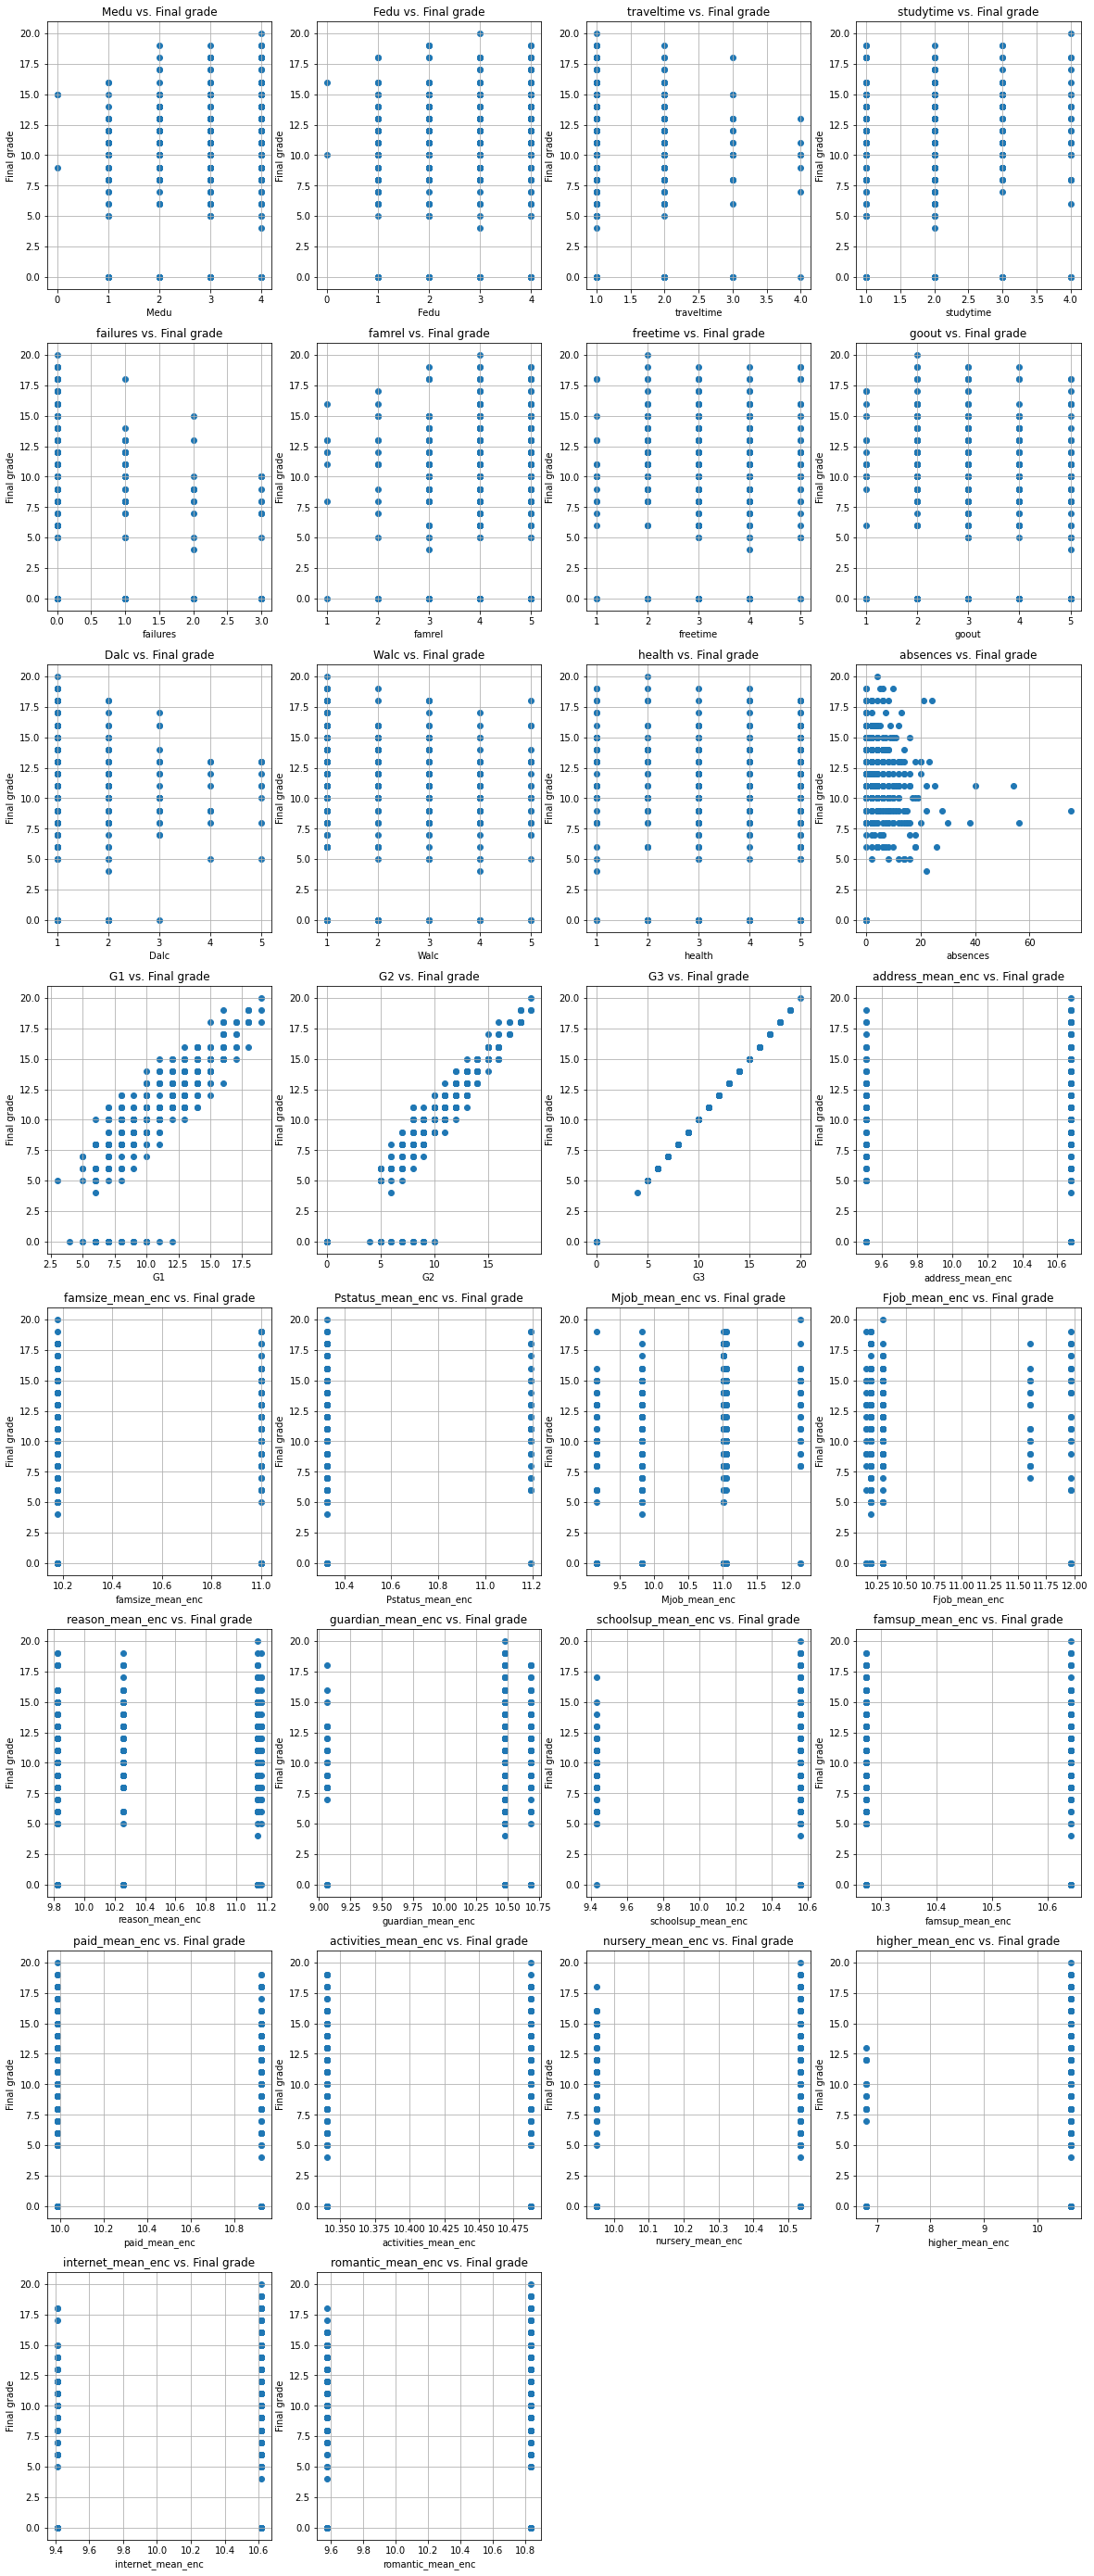

In [17]:
plt.figure(figsize=(20, 50))

for i in range(1, len(df.describe().columns)):
    plt.subplot(8, 4, i)
    title = str(df.describe().columns[i]) + ' vs. Final grade'
    plt.title(title)
    plt.xlabel(df.describe().columns[i])
    plt.ylabel('Final grade')
    plt.grid()
    plt.scatter(df[df.describe().columns[i]], df['G3'])    

In [18]:
df = df[df['G3'] != 0]

x_input = df[features]
x_input

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,address_mean_enc,famsize_mean_enc,Pstatus_mean_enc,Mjob_mean_enc,Fjob_mean_enc,reason_mean_enc,guardian_mean_enc,schoolsup_mean_enc,famsup_mean_enc,paid_mean_enc,activities_mean_enc,nursery_mean_enc,higher_mean_enc,internet_mean_enc,romantic_mean_enc
0,18,4,4,2,2,0,4,3,4,1,1,3,6,5,10.674267,10.177936,11.195122,9.152542,11.965517,9.820690,10.483516,9.431373,10.640523,9.985981,10.340206,10.535032,10.608,9.409091,10.836502
1,17,1,1,1,2,0,5,3,3,1,1,3,4,5,10.674267,10.177936,10.324859,9.152542,10.193548,9.820690,10.688889,10.561047,10.272727,9.985981,10.340206,9.950617,10.608,10.617021,10.836502
2,15,1,1,1,2,3,4,3,2,2,3,3,10,7,10.674267,11.000000,10.324859,9.152542,10.193548,11.166667,10.483516,9.431373,10.640523,10.922652,10.340206,10.535032,10.608,10.617021,10.836502
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15,10.674267,10.177936,10.324859,12.147059,10.297297,10.256881,10.483516,10.561047,10.272727,10.922652,10.487562,10.535032,10.608,10.617021,9.575758
4,16,3,3,1,2,0,4,3,2,1,2,5,4,6,10.674267,10.177936,10.324859,9.822695,10.193548,10.256881,10.688889,10.561047,10.272727,10.922652,10.340206,10.535032,10.608,9.409091,10.836502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,1,2,2,5,5,4,4,5,4,11,9,10.674267,11.000000,11.195122,11.019417,10.297297,9.820690,9.062500,10.561047,10.272727,10.922652,10.340206,10.535032,10.608,9.409091,10.836502
391,17,3,1,2,1,0,2,4,5,3,4,2,3,14,10.674267,11.000000,10.324859,11.019417,10.297297,9.820690,10.483516,10.561047,10.640523,9.985981,10.340206,9.950617,10.608,10.617021,10.836502
392,21,1,1,1,1,3,5,5,3,3,3,3,3,10,9.511364,10.177936,10.324859,9.822695,10.193548,9.820690,9.062500,10.561047,10.640523,9.985981,10.340206,9.950617,10.608,9.409091,10.836502
393,18,3,2,3,1,0,4,4,1,3,4,5,0,11,9.511364,11.000000,10.324859,11.019417,10.193548,9.820690,10.483516,10.561047,10.640523,9.985981,10.340206,9.950617,10.608,10.617021,10.836502


                     age  Medu  Fedu  traveltime  studytime  failures  famrel  \
age                  1.0   NaN   NaN         NaN        NaN       NaN     NaN   
Medu                 NaN   1.0   NaN         NaN        NaN       NaN     NaN   
Fedu                 NaN   NaN   1.0         NaN        NaN       NaN     NaN   
traveltime           NaN   NaN   NaN         1.0        NaN       NaN     NaN   
studytime            NaN   NaN   NaN         NaN        1.0       NaN     NaN   
failures             NaN   NaN   NaN         NaN        NaN       1.0     NaN   
famrel               NaN   NaN   NaN         NaN        NaN       NaN     1.0   
freetime             NaN   NaN   NaN         NaN        NaN       NaN     NaN   
goout                NaN   NaN   NaN         NaN        NaN       NaN     NaN   
Dalc                 NaN   NaN   NaN         NaN        NaN       NaN     NaN   
Walc                 NaN   NaN   NaN         NaN        NaN       NaN     NaN   
health               NaN   N

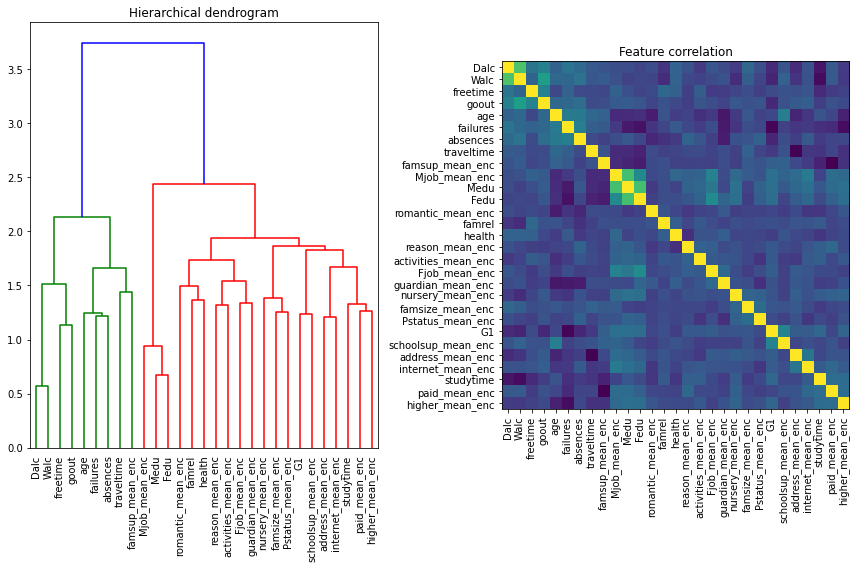

In [19]:
cor_table = x_input.corr()

print(cor_table[cor_table > 0.9])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

In [20]:
features = ['G1', 'absences', 'goout', 'age', 'famrel',
            'studytime', 'Medu', 'Walc', 'Mjob_mean_enc', 'freetime',
            'Fedu', 'Fjob_mean_enc']

x_input = df[features]
y_output = df['G3']

x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, random_state=42)

#**4. 데이터 스케일링**

In [21]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#**5. 모델 생성 및 최적화**

In [22]:
model_name = []
train_perf = []
test_perf = []

Fitting 5 folds for each of 2790 candidates, totalling 13950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 10504 tasks      | elapsed:   19.1s


Best_estimator: ElasticNet(alpha=0.009000000000000001, copy_X=True, fit_intercept=True,
           l1_ratio=0.9000000000000001, max_iter=100000000, normalize=False,
           positive=False, precompute=False, random_state=42,
           selection='cyclic', tol=3.16, warm_start=False)
Best_params: {'alpha': 0.009000000000000001, 'l1_ratio': 0.9000000000000001, 'tol': 3.16}
Best_score: 0.8083460489024213
Train score: 0.7804428063110727
Test  score: 0.7484576272786545


[Parallel(n_jobs=-1)]: Done 13947 out of 13950 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 13950 out of 13950 | elapsed:   24.8s finished


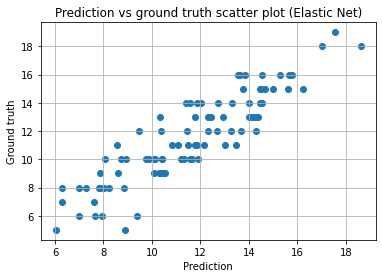

In [23]:
en_model = ElasticNet(max_iter=100000000, random_state=42)

en_param = {'l1_ratio': np.arange(0.70, 1, 0.01),
            'alpha': np.arange(0.001, 0.016, 0.001),
            'tol': [0.316, 1, 3.16, 10, 31.6, 100]}

clf = GridSearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=1)
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Elastic Net')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Elastic Net)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [24]:
en_model = ElasticNet(alpha=0.009, l1_ratio=0.9, tol=3.16, max_iter=100000000, random_state=42)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished


Best_estimator: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=110, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
Best_params: {'max_depth': 6, 'min_samples_split': 8, 'n_estimators': 110}
Best_score: 0.809597681927114
Train score: 0.8982988138805192
Test  score: 0.6615857240025546


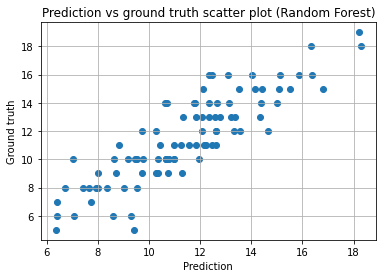

In [25]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)

rf_param = {'n_estimators': range(90, 140, 10),
            'max_depth': range(3, 8, 1),
            'min_samples_split': range(2, 10, 1)}

clf = GridSearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=1, cv=5)

clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Random Forest')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Random Forest)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [26]:
rf_model = RandomForestRegressor(max_depth=6, min_samples_split=8, n_estimators=110, n_jobs=-1, random_state=42)

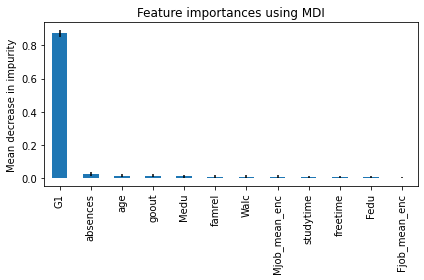

In [27]:
rf_model.fit(x_train_scaled, y_train)

feature_names = ['feature {i}' for i in range(x_train_scaled.shape[1])]

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
# ax.set_ylim(0, 0.05)
fig.tight_layout()

Index(['Fjob_mean_enc', 'Fedu', 'freetime', 'Mjob_mean_enc', 'Medu', 'Walc',
       'studytime', 'famrel', 'age', 'goout', 'absences', 'G1'],
      dtype='object')
[[0.00243772 0.00747817 0.00872839 ... 0.02354234 0.0340892  1.44664762]
 [0.00471614 0.0063939  0.00708553 ... 0.01467024 0.03293317 1.56382551]
 [0.00583772 0.00628238 0.0075397  ... 0.01723543 0.03683995 1.58411999]
 ...
 [0.00306746 0.00680108 0.00546976 ... 0.01485421 0.0369812  1.59336052]
 [0.00439624 0.00664298 0.00791953 ... 0.03274799 0.03050368 1.63742274]
 [0.00591074 0.00762931 0.00539629 ... 0.02852984 0.03988525 1.65293361]]


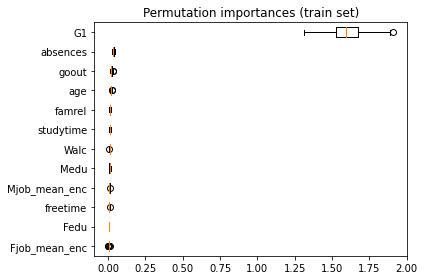

In [28]:
result = permutation_importance(rf_model, x_train_scaled, y_train, n_repeats=200, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])

print(x_train.columns[sorted_idx])
print(result.importances[sorted_idx].T)

ax.set_title("Permutation importances (train set)")
fig.tight_layout()

Train score: 0.7620004407947304
Test  score: 0.7322977605308391


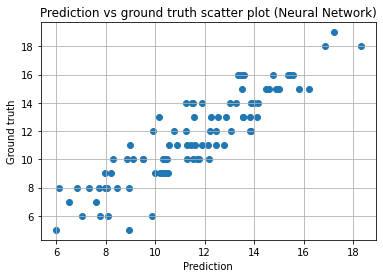

In [29]:
mlp_model = MLPRegressor(learning_rate='adaptive', max_iter=2000000, verbose=0,
                         early_stopping=True, random_state=42)

# mlp_param = {'hidden_layer_sizes': [x for x in itertools.product((range(7, 32)), repeat=2)],
#              'alpha': loguniform(1e-5, 1e-4)}

# rand_clf = RandomizedSearchCV(estimator=mlp_model, param_distributions=mlp_param, n_iter=5, n_jobs=-1,
#                               cv=3, verbose=2, random_state=42)

rand_clf = MLPRegressor(hidden_layer_sizes=(31, 7), alpha=2e-5, learning_rate='adaptive',
                        max_iter=2000000, verbose=0, early_stopping=True, random_state=42)

rand_clf.fit(x_train_scaled, y_train)

y_train_pred = rand_clf.predict(x_train_scaled)
y_test_pred = rand_clf.predict(x_test_scaled)

# print('Best_estimator:', rand_clf.best_estimator_)
# print('Best_params:', rand_clf.best_params_)
# print('Best_score:', rand_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Neural Network')
train_perf.append(train_score)
test_perf.append(test_score)
plt.title('Prediction vs ground truth scatter plot (Neural Network)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [30]:
mlp_model = MLPRegressor(hidden_layer_sizes=(31, 7), alpha=2e-5, learning_rate='adaptive',
                         max_iter=2000000, verbose=0, early_stopping=True, random_state=42)

Fitting 5 folds for each of 2100 candidates, totalling 10500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 5580 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 10108 tasks      | elapsed:  2.1min


[12:55:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=48,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=1, reg_lambda=0.0316, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
Best_params: {'max_depth': 2, 'n_estimators': 48, 'reg_alpha': 1, 'reg_lambda': 0.0316}
Best_score: 0.8069429928596424
Train score: 0.8037829920802654
Test  score: 0.7053520126296972


[Parallel(n_jobs=-1)]: Done 10500 out of 10500 | elapsed:  2.3min finished


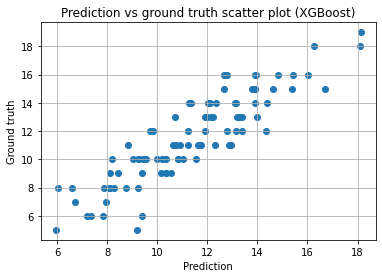

In [31]:
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)

xgb_param = {'n_estimators': range(40, 80, 2),
             'max_depth': range(2, 5, 1),
             'reg_alpha': [1e-2, 3.16e-2, 1e-1, 3.16e-1, 1, 3.16, 10],
             'reg_lambda': [1e-3, 3.16e-3, 1e-2, 3.16e-2, 1e-1]}

xgb_clf = GridSearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=2, cv=5)

xgb_clf.fit(x_train_scaled, y_train)
y_train_pred = xgb_clf.predict(x_train_scaled)
y_test_pred = xgb_clf.predict(x_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('XGBoost')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (XGBoost)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [32]:
xgb_model = XGBRegressor(max_depth=2, n_estimators=48, reg_alpha=1, reg_lambda=0.0316, n_jobs=-1, random_state=42)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   26.4s


Best_estimator: SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.00316,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best_params: {'C': 10000.0, 'gamma': 0.00316}
Best_score: 0.8024702732803167
Train score: 0.8034234792725734
Test  score: 0.7586133333739644


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished


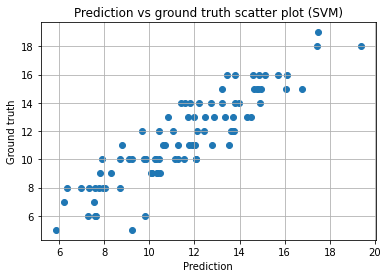

In [33]:
svr_model = SVR()

svr_param = {'C': [1e5, 3.16e5, 1e4, 3.16e4, 1e5],
             'gamma': [1e-4, 3.16e-4, 1e-3, 3.16e-3, 1e-2, 3.16e-2]}

svr_clf = GridSearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=3)

svr_clf.fit(x_train_scaled, y_train)
y_train_pred = svr_clf.predict(x_train_scaled)
y_test_pred = svr_clf.predict(x_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('SVM')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (SVM)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [34]:
svr_model = SVR(C=10000, gamma=0.00316)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.6s finished


Best_estimator: KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                    weights='distance')
Best_params: {'leaf_size': 1, 'n_neighbors': 4, 'weights': 'distance'}
Best_score: 0.4407902357017884
Train score: 1.0
Test  score: -0.26585052354944616


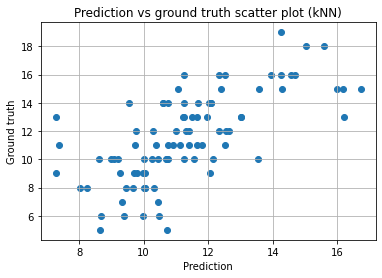

In [35]:
knn_model = KNeighborsRegressor(n_jobs=-1)

knn_param = {'n_neighbors': range(1, 6, 1),
             'weights': ['uniform', 'distance'],
             'leaf_size': range(1, 5, 1)}

knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_param, n_jobs=-1, verbose=3)

knn_clf.fit(x_train_scaled, y_train)
y_train_pred = knn_clf.predict(x_train_scaled)
y_test_pred = knn_clf.predict(x_test_scaled)

print('Best_estimator:', knn_clf.best_estimator_)
print('Best_params:', knn_clf.best_params_)
print('Best_score:', knn_clf.best_score_)
print('Train score:', r2_score(y_train_pred, y_train))
print('Test  score:', r2_score(y_test_pred, y_test))

plt.title('Prediction vs ground truth scatter plot (kNN)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

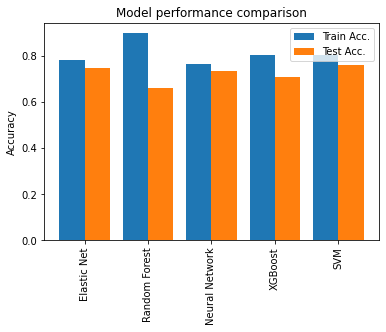

In [36]:
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

x = np.arange(len(model_name))
plt.xticks(x, model_name)
plt.bar(x - 0.2, train_perf, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf, width=0.4, label='Test Acc.')
plt.legend()

#**6. 모델 앙상블**

In [37]:
ensemble_list = [('en', en_model),
                 ('svm', svr_model),
                 ('mlp', mlp_model),
                 ('xgb', xgb_model),
                 ('rf', rf_model)]

voting_est = []

1 Ensemble train score: 0.7804428063110727
1 Ensemble test  score: 0.7484576272786545
2 Ensemble train score: 0.7949827670476454
2 Ensemble test  score: 0.755705718992754
3 Ensemble train score: 0.7865612991853814
3 Ensemble test  score: 0.7500627376424271
4 Ensemble train score: 0.7950846492958202
4 Ensemble test  score: 0.7443610515360242
5 Ensemble train score: 0.8230243239762552
5 Ensemble test  score: 0.7334832065104289


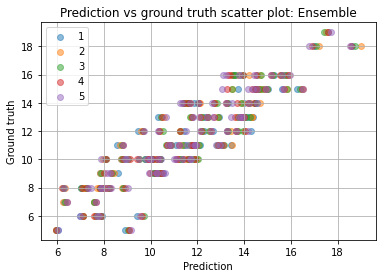

In [38]:
for idx, target_model in enumerate(ensemble_list):
    voting_est.append(target_model)

    voting_clf = VotingRegressor(estimators=voting_est, n_jobs=-1)
    voting_clf.fit(x_train_scaled, y_train)
    y_train_pred = voting_clf.predict(x_train_scaled)
    y_test_pred = voting_clf.predict(x_test_scaled)
    print(idx + 1, 'Ensemble train score:', r2_score(y_train_pred, y_train))
    print(idx + 1, 'Ensemble test  score:', r2_score(y_test_pred, y_test))

    plt.scatter(y_test_pred, y_test, label=str(idx + 1), alpha=0.5)
    title = 'Prediction vs ground truth scatter plot: Ensemble'
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground truth')
    plt.grid()
    plt.legend()

In [39]:
voting_clf = VotingRegressor(estimators=[('en', en_model), ('svm', svr_model), ('mlp', mlp_model)],
                             n_jobs=-1)

In [40]:
x_total = np.concatenate((x_train, x_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)

x_total_scaled = scaler.transform(x_total)

voting_clf.fit(x_total_scaled, y_total)

VotingRegressor(estimators=[('en',
                             ElasticNet(alpha=0.009, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.9,
                                        max_iter=100000000, normalize=False,
                                        positive=False, precompute=False,
                                        random_state=42, selection='cyclic',
                                        tol=3.16, warm_start=False)),
                            ('svm',
                             SVR(C=10000, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma=0.00316, kernel='rbf',
                                 max_iter=-1, shrinking=True,...
                                          beta_2=0.999, early_stopping=True,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(31, 7),
                                          learning_rate='adaptive',


#**7. 특성(피쳐) 중요도 분석**

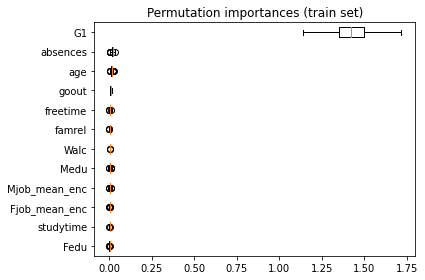

In [41]:
result = permutation_importance(voting_clf, x_train_scaled, y_train, n_repeats=500, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

In [42]:
features

['G1',
 'absences',
 'goout',
 'age',
 'famrel',
 'studytime',
 'Medu',
 'Walc',
 'Mjob_mean_enc',
 'freetime',
 'Fedu',
 'Fjob_mean_enc']

#**8. 유전 알고리즘 적용**

#**Task 1. 최대값 탐색**

In [43]:
# [GA 최대값 탐색]
# 1차 시험에서 평균점(20점중 11점)을 받은 학생이 공부를 아주 열심히 했을 경우 (studytime=4) 달성 가능한 최대 등급은?

In [44]:
# 0: 'G1',
# 1: 'absences',
# 2: 'goout',
# 3: 'age',
# 4: 'famrel',
# 5: 'studytime',
# 6: 'Medu',
# 7: 'Walc',
# 8: 'Mjob_mean_enc',
# 9: 'freetime',
# 10: 'Fedu',
# 11: 'Fjob_mean_enc'


def input_conversion(x_input):
    conversion = [int(x_input[0]),
                  int(x_input[1]),
                  int(x_input[2]),
                  int(x_input[3]),
                  int(x_input[4]),
                  int(x_input[5]),
                  int(x_input[6]),
                  int(x_input[7]),
                  Mjob_encode.iloc[int(x_input[8])], # enc
                  int(x_input[9]),
                  int(x_input[10]),
                  Fjob_encode.iloc[int(x_input[11])]] # enc

    return conversion

In [45]:
# 0: 'G1',
# 1: 'absences',
# 2: 'goout',
# 3: 'age',
# 4: 'famrel',
# 5: 'studytime',
# 6: 'Medu',
# 7: 'Walc',
# 8: 'Mjob_mean_enc',
# 9: 'freetime',
# 10: 'Fedu',
# 11: 'Fjob_mean_enc'

# varbound = np.array([[df['G1'].min(), df['G1'].max()],
#                      [df['absences'].min(), df['absences'].max()],
#                      [df['goout'].min(), df['goout'].max()],
#                      [df['age'].min(), df['age'].max()],
#                      [df['famrel'].min(), df['famrel'].max()],                     
#                      [df['studytime'].min(), df['studytime'].max()],
#                      [df['Medu'].min(), df['Medu'].max()],
#                      [df['Walc'].min(), df['Walc'].max()],
#                      [0, len(Mjob_encode) - 1],
#                      [df['freetime'].min(), df['freetime'].max()],
#                      [df['Fedu'].min(), df['Fedu'].max()],                     
#                      [0, len(Fjob_encode) - 1]])

varbound = np.array([[11, 11],
                     [df['absences'].min(), df['absences'].max()],
                     [df['goout'].min(), df['goout'].max()],
                     [df['age'].min(), df['age'].max()],
                     [df['famrel'].min(), df['famrel'].max()],                     
                     [4, 4],
                     [df['Medu'].min(), df['Medu'].max()],
                     [df['Walc'].min(), df['Walc'].max()],
                     [0, len(Mjob_encode) - 1],
                     [df['freetime'].min(), df['freetime'].max()],
                     [df['Fedu'].min(), df['Fedu'].max()],                     
                     [0, len(Fjob_encode) - 1]])

In [46]:
def object_function_t1(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)

    # target = 20.0
    # print('Predicted views:', int(prediction), 'Difference from target:', int(prediction - target))
    print('Predicted grade:', prediction[0])

    return pow(-prediction[0], 3)

In [47]:
algorithm_param = {'max_num_iteration': 500,
                   'population_size': 200,
                   'mutation_probability': 0.2,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

Streaming output truncated to the last 5000 lines.
Predicted grade: 11.529239056348606
Predicted grade: 13.001765197300065
Predicted grade: 11.137844569280809
Predicted grade: 11.411869759996732
Predicted grade: 11.769447228622711
Predicted grade: 12.4550455597824
Predicted grade: 12.380683426965666
Predicted grade: 12.244166769155393
Predicted grade: 12.5943899538413
Predicted grade: 11.128414421170937
Predicted grade: 12.88148752556256
Predicted grade: 13.074876982560147
Predicted grade: 12.057518770050274
Predicted grade: 11.431799096682644
Predicted grade: 12.692456845376292
Predicted grade: 12.900293357505328
Predicted grade: 12.15423414796291
Predicted grade: 13.329696847271604
Predicted grade: 11.631727239972498
Predicted grade: 8.780257093673518
Predicted grade: 12.667209828371712
Predicted grade: 11.369825047281049
Predicted grade: 12.150634726341337
Predicted grade: 12.536738806229422
Predicted grade: 12.538189766288307
Predicted grade: 12.878671103976728
Predicted grade: 12.

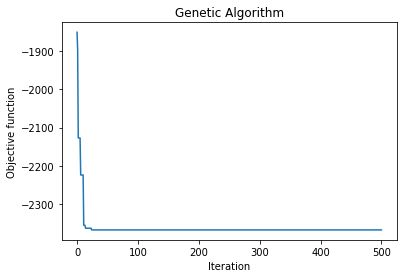

In [48]:
model_ga_t1 = geneticalgorithm(function=object_function_t1,
                               dimension=12,
                               variable_type='int',
                               variable_boundaries=varbound,
                               algorithm_parameters=algorithm_param)

model_ga_t1.run()

In [49]:
convergence_t1 = model_ga_t1.report
solution_t1 = model_ga_t1.output_dict

print(convergence_t1)
print(solution_t1)

[-1849.8357003377646, -1895.6096708747323, -2127.119624845031, -2127.119624845031, -2127.119624845031, -2127.119624845031, -2224.3101030411844, -2224.3101030411844, -2224.3101030411844, -2224.3101030411844, -2224.3101030411844, -2356.245451721784, -2356.245451721784, -2356.245451721784, -2363.9371469706953, -2363.9371469706953, -2363.9371469706953, -2363.9371469706953, -2363.9371469706953, -2363.9371469706953, -2363.9371469706953, -2363.9371469706953, -2363.9371469706953, -2363.9371469706953, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2368.431440050594, -2

In [50]:
ga_solution = input_conversion(solution_t1['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob_mean_enc,freetime,Fedu,Fjob_mean_enc
0,11.0,0.0,1.0,15.0,5.0,4.0,4.0,1.0,12.147059,1.0,4.0,10.15


In [51]:
Fjob = Fjob_encode[Fjob_encode.isin(ga_solution_df['Fjob_mean_enc'])].index[0]
ga_solution_df['Fjob_mean_enc'] = Fjob
ga_solution_df = ga_solution_df.rename(columns={'Fjob_mean_enc': 'Fjob'})

Mjob = Mjob_encode[Mjob_encode.isin(ga_solution_df['Mjob_mean_enc'])].index[0]
ga_solution_df['Mjob_mean_enc'] = Mjob
ga_solution_df = ga_solution_df.rename(columns={'Mjob_mean_enc': 'Mjob'})
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob
0,11.0,0.0,1.0,15.0,5.0,4.0,4.0,1.0,health,1.0,4.0,at_home


In [52]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['G3'] = prediction[0]
ga_solution_t1 = ga_solution_df
ga_solution_t1

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob,G3
0,11.0,0.0,1.0,15.0,5.0,4.0,4.0,1.0,health,1.0,4.0,at_home,13.329697


#**Task 2. 최소값 탐색**

In [53]:
# [GA 최소값 탐색]
# 중간고사에서 1등 (G1=19)한 최상위권 학생이 공부를 게을리했을 때 (study time 4 -> 1) 하락할 최대 등급은?

In [54]:
# 0: 'G1',
# 1: 'absences',
# 2: 'goout',
# 3: 'age',
# 4: 'famrel',
# 5: 'studytime',
# 6: 'Medu',
# 7: 'Walc',
# 8: 'Mjob_mean_enc',
# 9: 'freetime',
# 10: 'Fedu',
# 11: 'Fjob_mean_enc'

# varbound = np.array([[df['G1'].min(), df['G1'].max()],
#                      [df['absences'].min(), df['absences'].max()],
#                      [df['goout'].min(), df['goout'].max()],
#                      [df['age'].min(), df['age'].max()],
#                      [df['famrel'].min(), df['famrel'].max()],                     
#                      [df['studytime'].min(), df['studytime'].max()],
#                      [df['Medu'].min(), df['Medu'].max()],
#                      [df['Walc'].min(), df['Walc'].max()],
#                      [0, len(Mjob_encode) - 1],
#                      [df['freetime'].min(), df['freetime'].max()],
#                      [df['Fedu'].min(), df['Fedu'].max()],                     
#                      [0, len(Fjob_encode) - 1]])

varbound = np.array([[19, 19],
                     [df['absences'].min(), df['absences'].max()],
                     [df['goout'].min(), df['goout'].max()],
                     [df['age'].min(), df['age'].max()],
                     [df['famrel'].min(), df['famrel'].max()],                     
                     [1, 1],
                     [df['Medu'].min(), df['Medu'].max()],
                     [df['Walc'].min(), df['Walc'].max()],
                     [0, len(Mjob_encode) - 1],
                     [df['freetime'].min(), df['freetime'].max()],
                     [df['Fedu'].min(), df['Fedu'].max()],                     
                     [0, len(Fjob_encode) - 1]])

In [55]:
def object_function_t2(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)

    # target = 1.0
    # print('Predicted views:', int(prediction), 'Difference from target:', int(prediction - target))
    print('Predicted grade:', prediction[0]) 

    # return abs(int(prediction) - target)
    return pow(prediction[0], 3)    

Streaming output truncated to the last 5000 lines.
Predicted grade: 14.596465256551157
Predicted grade: 13.809711598523444
Predicted grade: 14.518708539881018
Predicted grade: 14.788895286853345
Predicted grade: 14.201130580778278
Predicted grade: 14.183499790000637
Predicted grade: 15.165033662574332
Predicted grade: 14.490952881403311
Predicted grade: 14.1737047542402
Predicted grade: 13.994682159853392
Predicted grade: 15.431198006541061
Predicted grade: 14.060953287174323
Predicted grade: 15.392213176328589
Predicted grade: 14.449919161465303
Predicted grade: 14.29402184171677
Predicted grade: 14.307083027887394
Predicted grade: 14.255710011729215
Predicted grade: 14.560914239957166
Predicted grade: 14.48098239593982
Predicted grade: 14.491462765919836
Predicted grade: 13.730228056247213
Predicted grade: 13.852931545253364
Predicted grade: 14.520160996810889
Predicted grade: 16.92848845877136
Predicted grade: 14.29707427293713
Predicted grade: 14.587877221970317
Predicted grade: 14

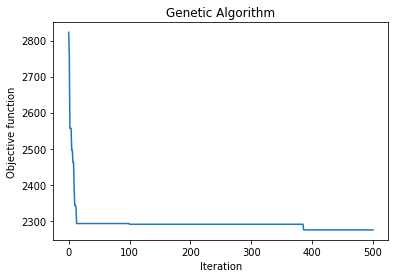

In [56]:
model_ga_t2 = geneticalgorithm(function=object_function_t2,
                               dimension=12,
                               variable_type='int',
                               variable_boundaries=varbound,
                               algorithm_parameters=algorithm_param)

model_ga_t2.run()

In [57]:
convergence_t2 = model_ga_t2.report
solution_t2 = model_ga_t2.output_dict

print(convergence_t2)
print(solution_t2)

[2822.935940549309, 2764.9258865508837, 2556.646619861934, 2556.646619861934, 2556.646619861934, 2496.338742080928, 2496.338742080928, 2461.497899119292, 2461.497899119292, 2389.3966813314482, 2342.7372724689494, 2342.7372724689494, 2339.177378646569, 2292.7658117708334, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.600144334166, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.587906980969, 2292.5

In [58]:
ga_solution = input_conversion(solution_t2['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob_mean_enc,freetime,Fedu,Fjob_mean_enc
0,19.0,75.0,5.0,22.0,1.0,1.0,0.0,1.0,9.152542,5.0,4.0,10.15


In [59]:
Fjob = Fjob_encode[Fjob_encode.isin(ga_solution_df['Fjob_mean_enc'])].index[0]
ga_solution_df['Fjob_mean_enc'] = Fjob
ga_solution_df = ga_solution_df.rename(columns={'Fjob_mean_enc': 'Fjob'})

Mjob = Mjob_encode[Mjob_encode.isin(ga_solution_df['Mjob_mean_enc'])].index[0]
ga_solution_df['Mjob_mean_enc'] = Mjob
ga_solution_df = ga_solution_df.rename(columns={'Mjob_mean_enc': 'Mjob'})
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob
0,19.0,75.0,5.0,22.0,1.0,1.0,0.0,1.0,at_home,5.0,4.0,at_home


In [60]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['G3'] = prediction[0]
ga_solution_t2 = ga_solution_df
ga_solution_t2

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob,G3
0,19.0,75.0,5.0,22.0,1.0,1.0,0.0,1.0,at_home,5.0,4.0,at_home,13.151889


#**Task 3. 목표값 탐색 + MC 시뮬레이션**

In [61]:
# [GA 목표값 탐색 + MC 시뮬레이션]
# 중위권 학생 (G3=11)의 결석일수 (absences=0 or 75)에 따른 성적 차이는 어떠한가?

In [62]:
# 0: 'G1',
# 1: 'absences',
# 2: 'goout',
# 3: 'age',
# 4: 'famrel',
# 5: 'studytime',
# 6: 'Medu',
# 7: 'Walc',
# 8: 'Mjob_mean_enc',
# 9: 'freetime',
# 10: 'Fedu',
# 11: 'Fjob_mean_enc'

# varbound = np.array([[df['G1'].min(), df['G1'].max()],
#                      [df['absences'].min(), df['absences'].max()],
#                      [df['goout'].min(), df['goout'].max()],
#                      [df['age'].min(), df['age'].max()],
#                      [df['famrel'].min(), df['famrel'].max()],                     
#                      [df['studytime'].min(), df['studytime'].max()],
#                      [df['Medu'].min(), df['Medu'].max()],
#                      [df['Walc'].min(), df['Walc'].max()],
#                      [0, len(Mjob_encode) - 1],
#                      [df['freetime'].min(), df['freetime'].max()],
#                      [df['Fedu'].min(), df['Fedu'].max()],                     
#                      [0, len(Fjob_encode) - 1]])

varbound = np.array([[df['G1'].min(), df['G1'].max()],
                     [df['absences'].min(), df['absences'].max()],
                     [df['goout'].min(), df['goout'].max()],
                     [df['age'].min(), df['age'].max()],
                     [df['famrel'].min(), df['famrel'].max()],                     
                     [df['studytime'].min(), df['studytime'].max()],
                     [df['Medu'].min(), df['Medu'].max()],
                     [df['Walc'].min(), df['Walc'].max()],
                     [0, len(Mjob_encode) - 1],
                     [df['freetime'].min(), df['freetime'].max()],
                     [df['Fedu'].min(), df['Fedu'].max()],                     
                     [0, len(Fjob_encode) - 1]])

In [63]:
def object_function_t3(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)

    target = 11.0
    print('Predicted views:', prediction[0], 'Difference from target:', prediction[0] - target)
    
    return math.log(abs(target - prediction[0])) 

Streaming output truncated to the last 5000 lines.
Predicted views: 10.89589155510152 Difference from target: -0.10410844489848081
Predicted views: 9.693398356599932 Difference from target: -1.306601643400068
Predicted views: 14.17448139068435 Difference from target: 3.1744813906843508
Predicted views: 11.67689423281889 Difference from target: 0.6768942328188903
Predicted views: 6.289795591645892 Difference from target: -4.710204408354108
Predicted views: 10.538005274449135 Difference from target: -0.4619947255508645
Predicted views: 11.049095814029158 Difference from target: 0.04909581402915819
Predicted views: 12.320470328688051 Difference from target: 1.3204703286880513
Predicted views: 11.396700011077959 Difference from target: 0.39670001107795905
Predicted views: 12.815259409576948 Difference from target: 1.8152594095769476
Predicted views: 11.691616960686183 Difference from target: 0.6916169606861828
Predicted views: 11.074402535444952 Difference from target: 0.07440253544495157


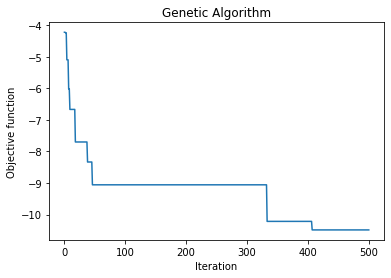

In [64]:
model_ga_t3 = geneticalgorithm(function=object_function_t3,
                               dimension=12,
                               variable_type='int',
                               variable_boundaries=varbound,
                               algorithm_parameters=algorithm_param)

model_ga_t3.run()

In [65]:
convergence_t3 = model_ga_t3.report
solution_t3 = model_ga_t3.output_dict

print(convergence_t3)
print(solution_t3)

[-4.2222734113400096, -4.2222734113400096, -4.239180024381901, -4.239180024381901, -5.095976062496617, -5.095976062496617, -5.095976062496617, -6.018322461921416, -6.018322461921416, -6.667353998241195, -6.667353998241195, -6.667353998241195, -6.667353998241195, -6.667353998241195, -6.667353998241195, -6.667353998241195, -6.667353998241195, -6.667353998241195, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -7.699133968415795, -8.33341318909957, -8.33341318909957, -8.33341318909957, -8.33341318909957, -8.33341318909957, -8.33341318909957, -8.33341318909957, -8.33341318909957, -9.056093798414853, -9.056093798414853, -9.056093798414853, -9.056093798414853, -9.05

In [66]:
ga_solution = input_conversion(solution_t3['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob_mean_enc,freetime,Fedu,Fjob_mean_enc
0,12.0,13.0,4.0,20.0,1.0,4.0,4.0,1.0,11.019417,3.0,3.0,11.611111


In [67]:
Fjob = Fjob_encode[Fjob_encode.isin(ga_solution_df['Fjob_mean_enc'])].index[0]
ga_solution_df['Fjob_mean_enc'] = Fjob
ga_solution_df = ga_solution_df.rename(columns={'Fjob_mean_enc': 'Fjob'})

Mjob = Mjob_encode[Mjob_encode.isin(ga_solution_df['Mjob_mean_enc'])].index[0]
ga_solution_df['Mjob_mean_enc'] = Mjob
ga_solution_df = ga_solution_df.rename(columns={'Mjob_mean_enc': 'Mjob'})
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob
0,12.0,13.0,4.0,20.0,1.0,4.0,4.0,1.0,services,3.0,3.0,health


In [68]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['G3'] = prediction[0]
ga_solution_t3 = ga_solution_df
ga_solution_t3

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob,G3
0,12.0,13.0,4.0,20.0,1.0,4.0,4.0,1.0,services,3.0,3.0,health,10.999972


In [99]:
inf_input = copy.deepcopy(model_ga_t3)

absence_min = []

for i in tqdm.tqdm(range(10000)):   
    inf_input.output_dict['variable'][0] = 12
    inf_input.output_dict['variable'][1] = 0
    inf_input.output_dict['variable'][2] = randint(df['goout'].min(), df['goout'].max())
    inf_input.output_dict['variable'][3] = randint(df['age'].min(), df['age'].max())
    inf_input.output_dict['variable'][4] = randint(df['famrel'].min(), df['famrel'].max())
    inf_input.output_dict['variable'][5] = randint(df['studytime'].min(), df['studytime'].max())
    inf_input.output_dict['variable'][6] = randint(df['Medu'].min(), df['Medu'].max())
    inf_input.output_dict['variable'][7] = randint(df['Walc'].min(), df['Walc'].max())
    inf_input.output_dict['variable'][8] = randint(0, len(Mjob_encode) - 1)
    inf_input.output_dict['variable'][9] = randint(df['freetime'].min(), df['freetime'].max())
    inf_input.output_dict['variable'][10] = randint(df['Fedu'].min(), df['Fedu'].max())
    inf_input.output_dict['variable'][11] = randint(0, len(Fjob_encode) - 1)

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    absence_min.append([i, prediction[0]])

100%|██████████| 10000/10000 [00:12<00:00, 799.13it/s]


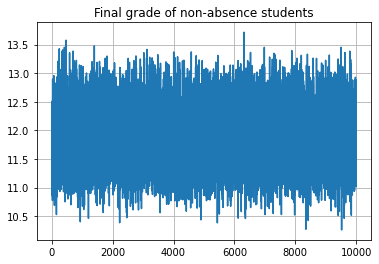

In [100]:
absence_min_df = pd.DataFrame(absence_min, columns=['trials', 'final_grade'])

plt.grid()
plt.title('Final grade of non-absence students')
plt.plot(absence_min_df['trials'], absence_min_df['final_grade'])

Average views: 11.910616125908168
Median views: 11.899728277714365
Standard deviation of views [count]: 0.5377808015838436
Standard deviation of views     [%]: 4.515138393336797


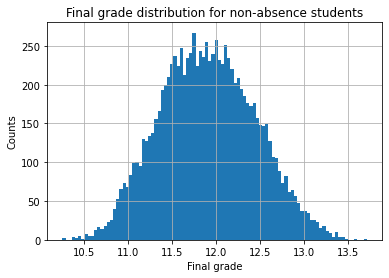

In [101]:
plt.grid()
plt.title('Final grade distribution for non-absence students')
plt.xlabel('Final grade')
plt.ylabel('Counts')
plt.hist(absence_min_df['final_grade'], bins=96)

print('Average views:', absence_min_df['final_grade'].mean())
print('Median views:', absence_min_df['final_grade'].median())
print('Standard deviation of views [count]:', absence_min_df['final_grade'].std())
print('Standard deviation of views     [%]:', absence_min_df['final_grade'].std()*100 / absence_min_df['final_grade'].mean())

In [102]:
inf_input = copy.deepcopy(model_ga_t3)

absence_max = []

for i in tqdm.tqdm(range(10000)):   
    inf_input.output_dict['variable'][0] = 12
    inf_input.output_dict['variable'][1] = 75
    inf_input.output_dict['variable'][2] = randint(df['goout'].min(), df['goout'].max())
    inf_input.output_dict['variable'][3] = randint(df['age'].min(), df['age'].max())
    inf_input.output_dict['variable'][4] = randint(df['famrel'].min(), df['famrel'].max())
    inf_input.output_dict['variable'][5] = randint(df['studytime'].min(), df['studytime'].max())
    inf_input.output_dict['variable'][6] = randint(df['Medu'].min(), df['Medu'].max())
    inf_input.output_dict['variable'][7] = randint(df['Walc'].min(), df['Walc'].max())
    inf_input.output_dict['variable'][8] = randint(0, len(Mjob_encode) - 1)
    inf_input.output_dict['variable'][9] = randint(df['freetime'].min(), df['freetime'].max())
    inf_input.output_dict['variable'][10] = randint(df['Fedu'].min(), df['Fedu'].max())
    inf_input.output_dict['variable'][11] = randint(0, len(Fjob_encode) - 1)

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    absence_max.append([i, prediction[0]])

100%|██████████| 10000/10000 [00:12<00:00, 805.03it/s]


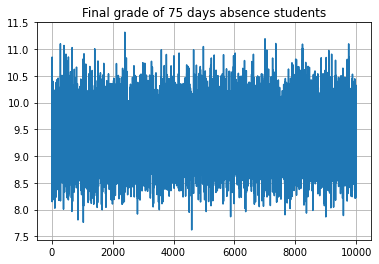

In [103]:
absence_max_df = pd.DataFrame(absence_max, columns=['trials', 'final_grade'])

plt.grid()
plt.title('Final grade of 75 days absence students')
plt.plot(absence_max_df['trials'], absence_max_df['final_grade'])

Average views: 9.391492005536788
Median views: 9.382155184263581
Standard deviation of views [count]: 0.5315370429529164
Standard deviation of views     [%]: 5.659772085623315


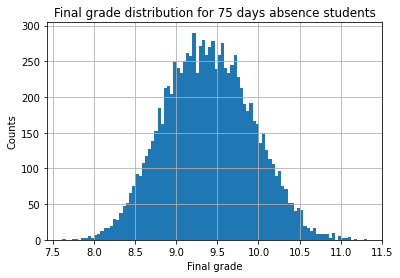

In [104]:
plt.grid()
plt.title('Final grade distribution for 75 days absence students')
plt.xlabel('Final grade')
plt.ylabel('Counts')
plt.hist(absence_max_df['final_grade'], bins=96)

print('Average views:', absence_max_df['final_grade'].mean())
print('Median views:', absence_max_df['final_grade'].median())
print('Standard deviation of views [count]:', absence_max_df['final_grade'].std())
print('Standard deviation of views     [%]:', absence_max_df['final_grade'].std()*100 / absence_max_df['final_grade'].mean())

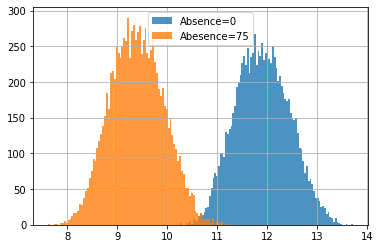

In [105]:
plt.hist(absence_min_df['final_grade'], bins=96, label='Absence=0', alpha=0.8)
plt.hist(absence_max_df['final_grade'], bins=96, label='Abesence=75', alpha=0.8)
plt.grid()
plt.legend()

#**Task 4. 목표값 탐색 + MC 시뮬레이션**

In [76]:
# [GA 목표값 탐색 + MC 시뮬레이션]
# 부모가 모두 대졸 (Medu = Fedu = 4)인 상위 25% (G3=14) 학생의 최종 등급 기대 분포를 구하라.

In [77]:
# 0: 'G1',
# 1: 'absences',
# 2: 'goout',
# 3: 'age',
# 4: 'famrel',
# 5: 'studytime',
# 6: 'Medu',
# 7: 'Walc',
# 8: 'Mjob_mean_enc',
# 9: 'freetime',
# 10: 'Fedu',
# 11: 'Fjob_mean_enc'

# varbound = np.array([[df['G1'].min(), df['G1'].max()],
#                      [df['absences'].min(), df['absences'].max()],
#                      [df['goout'].min(), df['goout'].max()],
#                      [df['age'].min(), df['age'].max()],
#                      [df['famrel'].min(), df['famrel'].max()],                     
#                      [df['studytime'].min(), df['studytime'].max()],
#                      [df['Medu'].min(), df['Medu'].max()],
#                      [df['Walc'].min(), df['Walc'].max()],
#                      [0, len(Mjob_encode) - 1],
#                      [df['freetime'].min(), df['freetime'].max()],
#                      [df['Fedu'].min(), df['Fedu'].max()],                     
#                      [0, len(Fjob_encode) - 1]])

varbound = np.array([[df['G1'].min(), df['G1'].max()],
                     [df['absences'].min(), df['absences'].max()],
                     [df['goout'].min(), df['goout'].max()],
                     [df['age'].min(), df['age'].max()],
                     [df['famrel'].min(), df['famrel'].max()],                     
                     [df['studytime'].min(), df['studytime'].max()],
                     [4, 4],
                     [df['Walc'].min(), df['Walc'].max()],
                     [0, len(Mjob_encode) - 1],
                     [df['freetime'].min(), df['freetime'].max()],
                     [4, 4],                     
                     [0, len(Fjob_encode) - 1]])

In [78]:
def object_function_t4(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)

    target = 14.0
    print('Predicted views:', prediction[0], 'Difference from target:', prediction[0] - target)
    
    return math.log(abs(target - prediction[0])) 

Streaming output truncated to the last 5000 lines.
Predicted views: 13.17838182887487 Difference from target: -0.8216181711251291
Predicted views: 14.006096550092217 Difference from target: 0.006096550092216546
Predicted views: 15.625326304016355 Difference from target: 1.6253263040163546
Predicted views: 9.115047793581656 Difference from target: -4.884952206418344
Predicted views: 14.231813274783889 Difference from target: 0.2318132747838888
Predicted views: 16.270535875505704 Difference from target: 2.270535875505704
Predicted views: 13.837011129817247 Difference from target: -0.16298887018275288
Predicted views: 13.41669183985347 Difference from target: -0.5833081601465295
Predicted views: 14.090265222690507 Difference from target: 0.09026522269050652
Predicted views: 14.24831650501291 Difference from target: 0.24831650501291058
Predicted views: 14.214414470534237 Difference from target: 0.214414470534237
Predicted views: 14.053171922491993 Difference from target: 0.0531719224919928

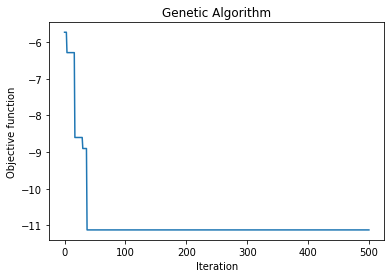

In [79]:
model_ga_t4 = geneticalgorithm(function=object_function_t4,
                               dimension=12,
                               variable_type='int',
                               variable_boundaries=varbound,
                               algorithm_parameters=algorithm_param)

model_ga_t4.run()

In [80]:
convergence_t4 = model_ga_t4.report
solution_t4 = model_ga_t4.output_dict

print(convergence_t4)
print(solution_t4)

[-5.728580757323003, -5.728580757323003, -5.728580757323003, -5.728580757323003, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -6.285006137510426, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.600869664353919, -8.901951682280586, -8.901951682280586, -8.901951682280586, -8.901951682280586, -8.901951682280586, -8.901951682280586, -8.901951682280586, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655, -11.12366504850655,

In [81]:
ga_solution = input_conversion(solution_t4['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob_mean_enc,freetime,Fedu,Fjob_mean_enc
0,15.0,22.0,1.0,18.0,4.0,1.0,4.0,5.0,9.822695,3.0,4.0,11.965517


In [82]:
Fjob = Fjob_encode[Fjob_encode.isin(ga_solution_df['Fjob_mean_enc'])].index[0]
ga_solution_df['Fjob_mean_enc'] = Fjob
ga_solution_df = ga_solution_df.rename(columns={'Fjob_mean_enc': 'Fjob'})

Mjob = Mjob_encode[Mjob_encode.isin(ga_solution_df['Mjob_mean_enc'])].index[0]
ga_solution_df['Mjob_mean_enc'] = Mjob
ga_solution_df = ga_solution_df.rename(columns={'Mjob_mean_enc': 'Mjob'})
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob
0,15.0,22.0,1.0,18.0,4.0,1.0,4.0,5.0,other,3.0,4.0,teacher


In [83]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['G3'] = prediction[0]
ga_solution_t4 = ga_solution_df
ga_solution_t4

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob,G3
0,15.0,22.0,1.0,18.0,4.0,1.0,4.0,5.0,other,3.0,4.0,teacher,13.999985


In [84]:
inf_input = copy.deepcopy(model_ga_t4)

distribution = []

for i in tqdm.tqdm(range(10000)):       
    inf_input.output_dict['variable'][1] = randint(df['absences'].min(), df['absences'].max())
    inf_input.output_dict['variable'][2] = randint(df['goout'].min(), df['goout'].max())
    inf_input.output_dict['variable'][3] = randint(df['age'].min(), df['age'].max())
    inf_input.output_dict['variable'][4] = randint(df['famrel'].min(), df['famrel'].max())
    inf_input.output_dict['variable'][5] = randint(df['studytime'].min(), df['studytime'].max())    
    inf_input.output_dict['variable'][7] = randint(df['Walc'].min(), df['Walc'].max())
    inf_input.output_dict['variable'][8] = randint(0, len(Mjob_encode) - 1)
    inf_input.output_dict['variable'][9] = randint(df['freetime'].min(), df['freetime'].max())    
    inf_input.output_dict['variable'][11] = randint(0, len(Fjob_encode) - 1)

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    distribution.append([i, prediction[0]])

100%|██████████| 10000/10000 [00:11<00:00, 858.89it/s]


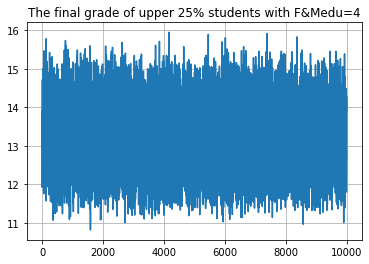

In [85]:
distribution_df = pd.DataFrame(distribution, columns=['trials', 'final_grade'])

plt.grid()
plt.title('The final grade of upper 25% students with F&Medu=4')
plt.plot(distribution_df['trials'], distribution_df['final_grade'])

Average views: 13.276152850655949
Median views: 13.262727132790175
Standard deviation of views [count]: 0.902331925139465
Standard deviation of views     [%]: 6.796637062632814


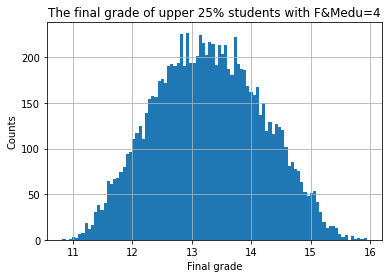

In [86]:
plt.grid()
plt.title('The final grade of upper 25% students with F&Medu=4')
plt.xlabel('Final grade')
plt.ylabel('Counts')
plt.hist(distribution_df['final_grade'], bins=96)

print('Average views:', distribution_df['final_grade'].mean())
print('Median views:', distribution_df['final_grade'].median())
print('Standard deviation of views [count]:', distribution_df['final_grade'].std())
print('Standard deviation of views     [%]:', distribution_df['final_grade'].std()*100 / distribution_df['final_grade'].mean())

#**Task 5. 목표값 탐색 + 변화량 분석**

In [87]:
# [GA 목표값 탐색 + 변화량 분석]
# 위 학생 공부시간 (study time)에 따른 최종 등급을 구하라.

In [88]:
inf_input = copy.deepcopy(model_ga_t4)

studytime_dep = []

for i in tqdm.tqdm(range(df['studytime'].min(), df['studytime'].max() + 1)):   
    inf_input.output_dict['variable'][5] = i

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    studytime_dep.append([i, prediction[0]])

100%|██████████| 4/4 [00:00<00:00, 823.26it/s]


<BarContainer object of 4 artists>

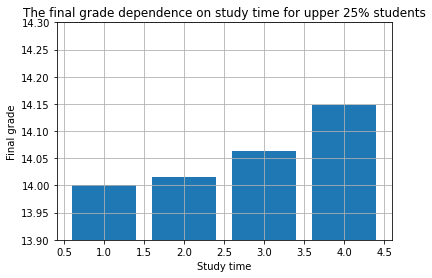

In [89]:
studytime_dep_df = pd.DataFrame(studytime_dep, columns=['studytime', 'G3'])

plt.title('The final grade dependence on study time for upper 25% students')
plt.xlabel('Study time')
plt.ylabel('Final grade')
plt.ylim(13.9, 14.3)
plt.grid()
plt.bar(studytime_dep_df['studytime'], studytime_dep_df['G3'])

#**Task 6. 최적해 탐색**

In [90]:
# [GA 최적해 탐색]
# 최대 등급 달성 (target G3 > 19.7) 가능 case를 제시하라.

In [91]:
# 0: 'G1',
# 1: 'absences',
# 2: 'goout',
# 3: 'age',
# 4: 'famrel',
# 5: 'studytime',
# 6: 'Medu',
# 7: 'Walc',
# 8: 'Mjob_mean_enc',
# 9: 'freetime',
# 10: 'Fedu',
# 11: 'Fjob_mean_enc'

varbound = np.array([[df['G1'].min(), df['G1'].max()],
                     [df['absences'].min(), df['absences'].max()],
                     [df['goout'].min(), df['goout'].max()],
                     [df['age'].min(), df['age'].max()],
                     [df['famrel'].min(), df['famrel'].max()],                     
                     [df['studytime'].min(), df['studytime'].max()],
                     [df['Medu'].min(), df['Medu'].max()],
                     [df['Walc'].min(), df['Walc'].max()],
                     [0, len(Mjob_encode) - 1],
                     [df['freetime'].min(), df['freetime'].max()],
                     [df['Fedu'].min(), df['Fedu'].max()],                     
                     [0, len(Fjob_encode) - 1]])

In [92]:
def object_function_t6(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)

    # target = 20.0
    # print('Predicted views:', int(prediction), 'Difference from target:', int(prediction - target))
    print('Predicted grade:', prediction[0])

    return pow(-prediction[0], 3)

Streaming output truncated to the last 5000 lines.
Predicted grade: 18.106493049046858
Predicted grade: 16.865258512215497
Predicted grade: 17.36367807142447
Predicted grade: 18.26999666955945
Predicted grade: 15.929112147459344
Predicted grade: 17.081265174162183
Predicted grade: 19.236402125585446
Predicted grade: 7.993774885012523
Predicted grade: 17.724952418264994
Predicted grade: 17.807221626780706
Predicted grade: 16.600909554734518
Predicted grade: 14.120968234825751
Predicted grade: 17.426398506416135
Predicted grade: 11.089141762289879
Predicted grade: 19.171724036725763
Predicted grade: 17.39780964097231
Predicted grade: 18.242671949985862
Predicted grade: 17.39406152970597
Predicted grade: 18.788406535468823
Predicted grade: 18.521516743317342
Predicted grade: 16.841491765141495
Predicted grade: 17.836496694621
Predicted grade: 17.143672518477885
Predicted grade: 13.152573228365162
Predicted grade: 17.632544745451067
Predicted grade: 19.548572670329182
Predicted grade: 19.3

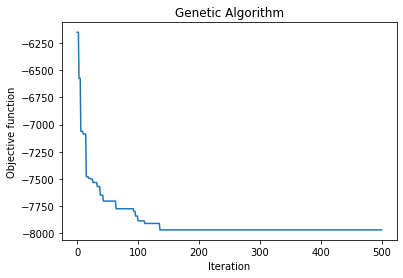

In [93]:
model_ga_t6 = geneticalgorithm(function=object_function_t6,
                               dimension=12,
                               variable_type='int',
                               variable_boundaries=varbound,
                               algorithm_parameters=algorithm_param)

model_ga_t6.run()

In [94]:
convergence_t6 = model_ga_t6.report
solution_t6 = model_ga_t6.output_dict

print(convergence_t6)
print(solution_t6)

[-6151.56637819406, -6151.56637819406, -6151.56637819406, -6574.722673353794, -6574.722673353794, -6574.722673353794, -7060.654411359658, -7060.654411359658, -7060.654411359658, -7060.654411359658, -7086.764829994161, -7086.764829994161, -7086.764829994161, -7086.764829994161, -7086.764829994161, -7479.100954385977, -7479.100954385977, -7479.100954385977, -7479.100954385977, -7494.060674874218, -7494.060674874218, -7494.060674874218, -7494.060674874218, -7502.265840035761, -7502.265840035761, -7502.265840035761, -7532.30388110656, -7532.30388110656, -7532.30388110656, -7532.30388110656, -7532.30388110656, -7532.30388110656, -7532.30388110656, -7569.342887199098, -7569.342887199098, -7569.342887199098, -7569.342887199098, -7569.342887199098, -7648.225429081636, -7648.225429081636, -7648.225429081636, -7648.225429081636, -7648.225429081636, -7703.150266186699, -7703.150266186699, -7703.150266186699, -7703.150266186699, -7703.150266186699, -7703.150266186699, -7703.150266186699, -7703.150

In [95]:
ga_solution = input_conversion(solution_t6['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob_mean_enc,freetime,Fedu,Fjob_mean_enc
0,19.0,0.0,1.0,15.0,5.0,4.0,4.0,1.0,12.147059,1.0,4.0,10.15


In [96]:
Fjob = Fjob_encode[Fjob_encode.isin(ga_solution_df['Fjob_mean_enc'])].index[0]
ga_solution_df['Fjob_mean_enc'] = Fjob
ga_solution_df = ga_solution_df.rename(columns={'Fjob_mean_enc': 'Fjob'})

Mjob = Mjob_encode[Mjob_encode.isin(ga_solution_df['Mjob_mean_enc'])].index[0]
ga_solution_df['Mjob_mean_enc'] = Mjob
ga_solution_df = ga_solution_df.rename(columns={'Mjob_mean_enc': 'Mjob'})
ga_solution_df

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob
0,19.0,0.0,1.0,15.0,5.0,4.0,4.0,1.0,health,1.0,4.0,at_home


In [97]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['G3'] = prediction[0]
ga_solution_t6 = ga_solution_df
ga_solution_t6

,G1,absences,goout,age,famrel,studytime,Medu,Walc,Mjob,freetime,Fedu,Fjob,G3
0,19.0,0.0,1.0,15.0,5.0,4.0,4.0,1.0,health,1.0,4.0,at_home,19.9734


In [98]:
df.sort_values(by='G3', ascending=False)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,address_mean_enc,famsize_mean_enc,Pstatus_mean_enc,Mjob_mean_enc,Fjob_mean_enc,reason_mean_enc,guardian_mean_enc,schoolsup_mean_enc,famsup_mean_enc,paid_mean_enc,activities_mean_enc,nursery_mean_enc,higher_mean_enc,internet_mean_enc,romantic_mean_enc
47,GP,M,16,U,GT3,T,4,3,health,services,reputation,mother,1,4,0,no,no,no,yes,yes,yes,yes,no,4,2,2,1,1,2,4,19,19,20,10.674267,10.177936,10.324859,12.147059,10.297297,11.142857,10.483516,10.561047,10.640523,9.985981,10.487562,10.535032,10.608,10.617021,10.836502
286,GP,F,18,U,GT3,T,2,2,at_home,at_home,other,mother,1,3,0,no,yes,yes,no,yes,yes,yes,no,4,3,3,1,2,2,5,18,18,19,10.674267,10.177936,10.324859,9.152542,10.150000,11.166667,10.483516,10.561047,10.272727,10.922652,10.340206,10.535032,10.608,10.617021,10.836502
110,GP,M,15,U,LE3,A,4,4,teacher,teacher,course,mother,1,1,0,no,no,no,yes,yes,yes,yes,no,5,5,3,1,1,4,6,18,19,19,10.674267,11.000000,11.195122,11.051724,11.965517,9.820690,10.483516,10.561047,10.640523,9.985981,10.487562,10.535032,10.608,10.617021,10.836502
113,GP,M,15,U,LE3,T,4,2,teacher,other,course,mother,1,1,0,no,no,no,no,yes,yes,yes,no,3,5,2,1,1,3,10,18,19,19,10.674267,11.000000,10.324859,11.051724,10.193548,9.820690,10.483516,10.561047,10.640523,9.985981,10.340206,10.535032,10.608,10.617021,10.836502
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,16,18,19,10.674267,11.000000,11.195122,11.019417,10.193548,10.256881,10.483516,10.561047,10.272727,10.922652,10.340206,10.535032,10.608,10.617021,10.836502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,MS,F,17,R,GT3,T,1,2,other,other,course,mother,1,1,0,no,no,no,yes,yes,yes,yes,no,3,5,5,1,3,1,14,6,5,5,9.511364,10.177936,10.324859,9.822695,10.193548,9.820690,10.483516,10.561047,10.640523,9.985981,10.487562,10.535032,10.608,10.617021,10.836502
79,GP,F,16,U,GT3,T,3,4,at_home,other,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,2,4,3,1,2,3,12,5,5,5,10.674267,10.177936,10.324859,9.152542,10.193548,9.820690,10.483516,10.561047,10.272727,9.985981,10.340206,10.535032,10.608,10.617021,10.836502
72,GP,F,15,R,GT3,T,1,1,other,other,reputation,mother,1,2,2,yes,yes,no,no,no,yes,yes,yes,3,3,4,2,4,5,2,8,6,5,9.511364,10.177936,10.324859,9.822695,10.193548,11.142857,10.483516,9.431373,10.272727,9.985981,10.340206,9.950617,10.608,10.617021,9.575758
384,MS,M,18,R,GT3,T,4,2,other,other,home,father,2,1,1,no,no,yes,no,yes,yes,no,no,5,4,3,4,3,3,14,6,5,5,9.511364,10.177936,10.324859,9.822695,10.193548,10.256881,10.688889,10.561047,10.640523,10.922652,10.340206,10.535032,10.608,9.409091,10.836502
